In [1]:
import xarray as xr
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import skill_metrics as sm
# import proplot as pplt

# 泰勒图绘制

2021.08.15

计算年际变化（时间序列）的taylor 图

2021.08.16

继续使用skillmetics包进行

将数据处理为字典，便于按照某个特征进行索引

泰勒图上的每个小点会单独绘制，按照特征给予不同的风格

2021.08.25

绘制整个空间上的taylor图，辅助空间pattern说明平均态下的各个统计指标的情况

2022.01.12

更换平均态的指标，考虑新计算的 extreme indices 的平均态的状况

## 数据读入

包含平均态以及计算出的极端指数

In [2]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/pre/ordata/"
filename_obs  = "obsmerge_pre_98-17.nc"
filename_vr     = "vr_pre_98-17.nc"
filename_rcm    = "rcm_pre_98-17.nc"

ds_or = {}
ds_or['obs'] = xr.open_dataset(dir_in + filename_obs)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['obs'] = ds_or['obs']['premerge']#[:,  :, :]
var['vr'] = ds_or['vr']['precip_MPAS']
var['rcm'] = ds_or['rcm']['precip_MPAS']

var['obs'] = var['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords

# change coords
var_list = ['obs', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['obs'].coords.keys()))
#     # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['obs']._coords
    var[i] = var[i].rename(i)

time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [3]:
ds_in_extreme = {}
for mod_name in ['obs','vr', 'rcm']:
    ds_in_extreme[mod_name] = {}
    ds_in_extreme[mod_name]['am'] = xr.open_dataset("/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/pre/extreme/extreme_"+mod_name+"_4-5.nc", decode_times = False)
    ds_in_extreme[mod_name]['jja'] = xr.open_dataset("/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/pre/extreme/extreme_"+mod_name+"_6-8.nc", decode_times = False)

vars_names = list(ds_in_extreme[mod_name]['am'].variables)[3:]
vars_names

['RX5day', 'SDII', 'CDD', 'CWD']

## 计算部分

### 平均态计算

In [4]:
indices_mean = {}

time_idx = {}
time_idx['am'] = var['obs'].time.dt.month.isin([4,5])
time_idx['jja'] = var['obs'].time.dt.month.isin([6,7,8])

for mod_name in ['obs', 'vr', 'rcm']:
    indices_mean[mod_name] = {}
    for iseason in ['am','jja']:
        indices_mean[mod_name][iseason] = {}
        # 平均态
        var_selmonth = var[mod_name].isel(time = time_idx[iseason]) # 选取月份的mod变量，后续通过它计算指标
        indices_mean[mod_name][iseason]['mean'] =  var_selmonth.mean(dim = "time")
        # 计算出的极端指数
        for index_name in vars_names:
            indices_mean[mod_name][iseason][index_name] = ds_in_extreme[mod_name][iseason][index_name].mean(dim = 'time')

### 泰勒图诸要素计算

In [5]:
def nested_dict():
    from collections import defaultdict
    return defaultdict(nested_dict)
# 进行mask，并且整理成1D数组，得到1D-pattern，用于后续的计算
# 计算指数的平均值
indices_names = list(indices_mean['obs']['am'].keys())

indices_mean_1d = nested_dict()
for mod_name in ['obs', 'vr', 'rcm']:
    for iseason in ['am','jja']:
        for count_way in indices_names:
            # 获取1D的平均态 并以RCM为基础进行NAN的MASK
            rcm_not_nan = ( ~np.isnan(indices_mean['rcm'][iseason][count_way])) &\
                 (~np.isnan(indices_mean['obs'][iseason][count_way])) &\
                 (~np.isnan(indices_mean['vr'][iseason][count_way]) )
            var_1d_temp = xr.where(rcm_not_nan, indices_mean[mod_name][iseason][count_way], np.nan).values.ravel()
            indices_mean_1d[mod_name][iseason][count_way] = var_1d_temp[~np.isnan(var_1d_temp)]
# shape check
# for iseason in ['am','jja']:
#     for count_way in indices_names:
#         print("shape check!\n OBS     VR     RCM")
#         print(str(indices_mean_1d['obs'][iseason][count_way].shape) +' '\
#         +str(indices_mean_1d['vr'][iseason][count_way].shape) +' ' \
#         +str(indices_mean_1d['rcm'][iseason][count_way].shape))

In [6]:
# 计算泰勒图诸要素 到字典taylor_ts中

# 进行mask，并且整理成1D数组，得到1D-pattern，用于后续的计算
# 计算指数的平均值
taylor_space = nested_dict()

for mod_name in ['obs', 'vr', 'rcm']:
    for iseason in ['am','jja']:
        for count_way in indices_names:
            taylor_space[mod_name][iseason][count_way] = {} 
            temp_obs = indices_mean_1d['obs'][iseason][count_way]
            temp_mod = indices_mean_1d[mod_name][iseason][count_way]
            # remove nan
            temp_obs = temp_obs[~np.isnan(temp_obs)]
            temp_mod = temp_mod[~np.isnan(temp_mod)]
            # taylor count
            taylor_space[mod_name][iseason][count_way] = sm.taylor_statistics(temp_mod, temp_obs)
            # normalized 注意先后顺序，先归一化CRMSD，再SDEV，否则用归一化后的SDEV计算RMSD会出现问题
            taylor_space[mod_name][iseason][count_way]['crmsd'] = taylor_space[mod_name][iseason][count_way]['crmsd'] / taylor_space[mod_name][iseason][count_way]['sdev'][0]
            taylor_space[mod_name][iseason][count_way]['sdev'] = taylor_space[mod_name][iseason][count_way]['sdev'] / taylor_space[mod_name][iseason][count_way]['sdev'][0]

## 绘图部分

逐个点的绘制泰勒图，单独为每个点的属性设置相应的特征

### 检查数据-制表

In [7]:
table_taylor_metrics = []
for model in ['vr', 'rcm']:
    for season in ['am','jja']:
        table_temp = pd.DataFrame.from_dict( taylor_space[model][season] ) 
        table_temp['model']  = model
        table_temp['season'] = season
        table_taylor_metrics.append(table_temp)

table_taylor_metrics = pd.concat(table_taylor_metrics)
# table_taylor_metrics
# table_taylor_metrics.loc['crmse']

for i in indices_names:
    real_values = np.array([i[1] for i in table_taylor_metrics[i].values])
    table_taylor_metrics[i] = real_values
    
# table_taylor_metrics.loc['sdev']
table_taylor_metrics.to_csv("./output_table/pre_SpatialTaylor_Indices_2022.01.12.csv")

In [8]:
indices_names

['mean', 'RX5day', 'SDII', 'CDD', 'CWD']

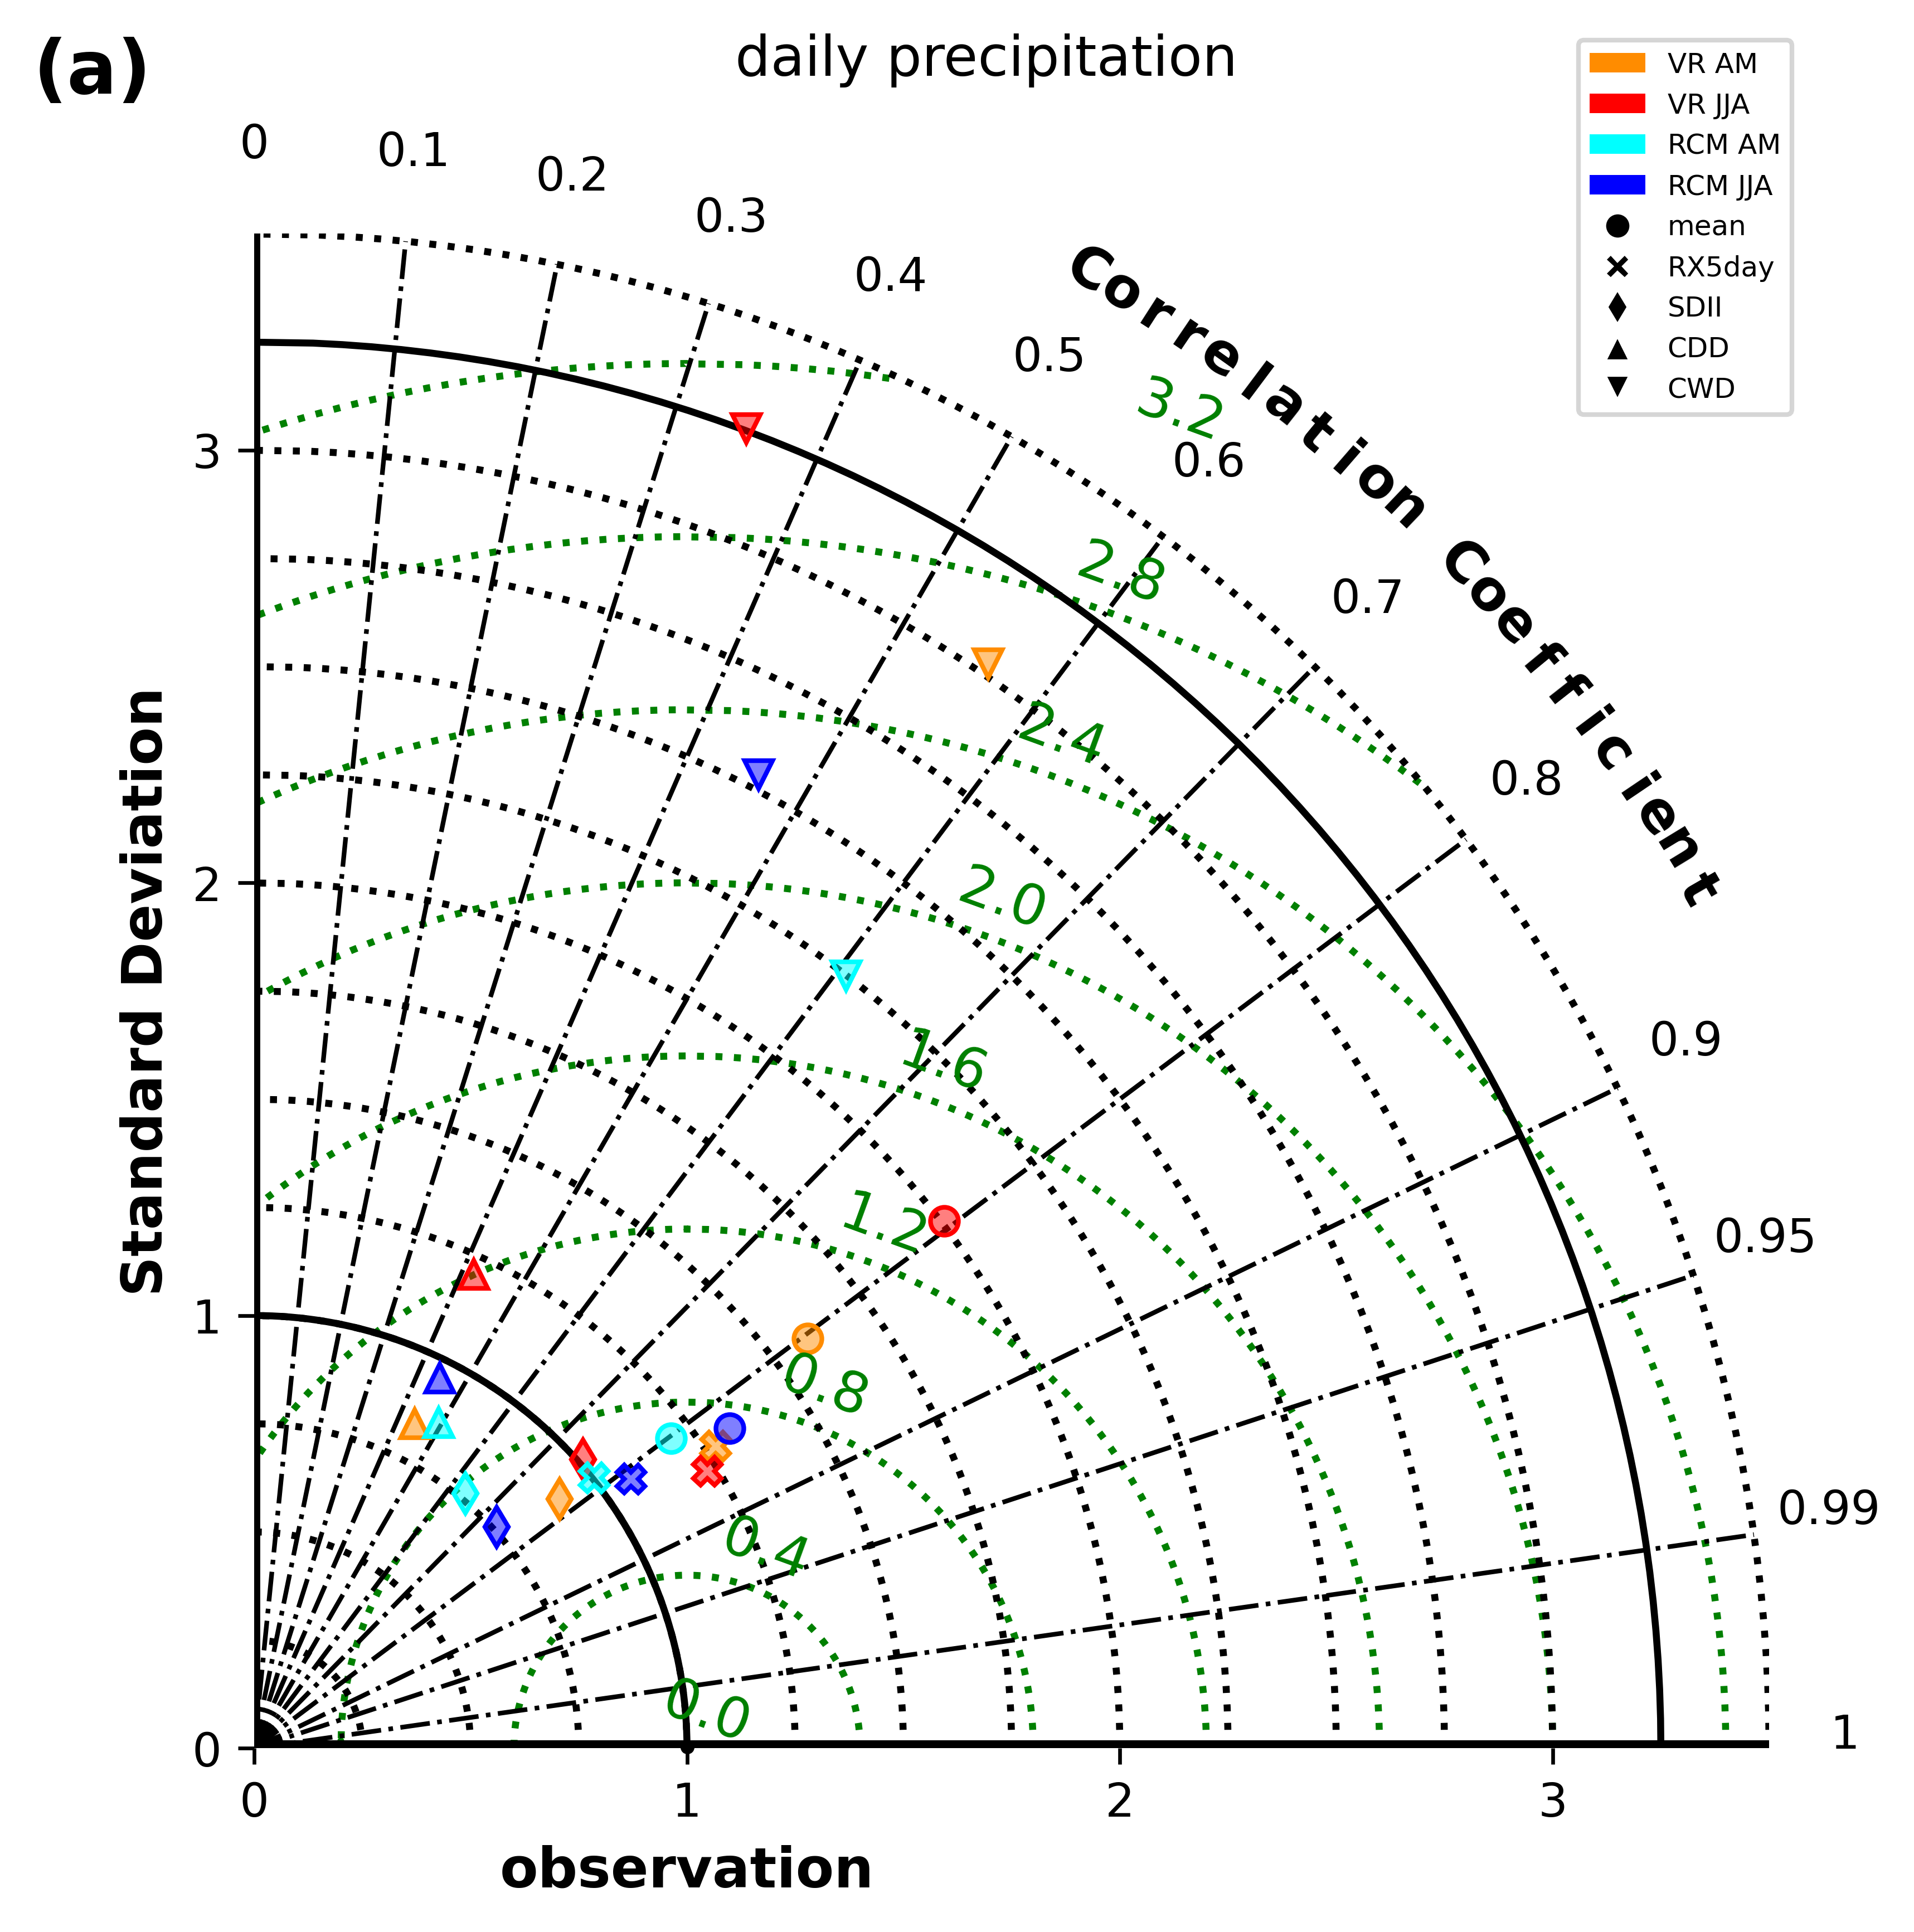

In [9]:
# import skill_metrics as sm
# import importlib
# importlib.reload(sm)

# fig, axs = pplt.subplots(ncols=1 ,nrows=1)
fig = plt.figure(figsize=(6, 6), dpi=600)

first_plot = False # 用作后续overlay设置

# 创建风格的dict,之后传入每个单独的点来进行绘制
# # Define markers
# kind = ['+','o','x','s','d','^','v','p','h','*']
# colorm = ['b','r','g','c','m','y','k']
imodiseason_color = {'vr am':"darkorange", 'vr jja':"red",'rcm am':'cyan', "rcm jja":"blue"}
# iregion_style_color = {"NE":"m", "NC":"y", "YZ":"c", "SC":"b",'SW':"g",'NWC':"tab:gray"}
# iseason_style_marker = {'am':'.',"jja":'v'}

count_way_marker = {'mean':"o","RX5day":"X","SDII":"d","CDD":"^", 'CWD':"v"}
really_names     = dict(zip(indices_names, indices_names))

for imod in ['vr','rcm']:
    for iseason in ['am','jja']:
        for count_way in  indices_names:
            # 获取每个点的泰勒图诸要素
            sdev_plot = taylor_space[imod][iseason][count_way]['sdev']
            crmsd_plot = taylor_space[imod][iseason][count_way]['crmsd']
            ccoef_plot = taylor_space[imod][iseason][count_way]['ccoef']

            sm.taylor_diagram(sdev_plot,crmsd_plot,ccoef_plot, 
                #----- mark setting -----
                MarkerDisplayed = 'marker',
                # markerLabel = label2, 
                # numberPanels = 1,
                # markerLabel = ['obs','vr','rcm'],
                # markerLabel = ['obs', imod.upper()],
                # markerLabelColor = imod_style_color[imod],
                markerlegend = "off",
                markerColor = imodiseason_color[imod + " " + iseason],
                # markerColor = 'k',
                markerSize = 6,
                alpha = .5, 
                # -----RNSD-----
                # tickRMS = np.arange(0,1.8,0.2),
                tickRMS = np.arange(0,3.6,0.4),
                tickRMSangle = 70, 
                colRMS = 'g', styleRMS = ':', widthRMS = 1.5,
                # tickCOR = lsCOR,
                showlabelsRMS = "on",
                titleRMS = "off",
                rmslabelformat = ':.1f',
                # -----COR-----
                colCOR = "k", 
                widthCOR = 1.0,
                # -----STD------
                tickSTD = np.arange(0,3.5,0.25), axismax = 3.5, 
                showlabelsSTD = 'on',
                # markersymbol = iseason_style_marker[iseason],
                # markersymbol = combine_mod_season_marker[imod + " " + iseason],
                markersymbol = count_way_marker[count_way],
                # -----marker reference-----
                styleOBS = '-', 
                colOBS = 'k',
                markerobs = 'o', 
                overlay = first_plot,
                titleOBS = 'observation',
                # ------ check -----
                checkStats = True,
            )
            # break
            first_plot = True


# legend设置，颜色以及型号
# custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = []
for i in imodiseason_color.items():
    legend_elements.append( Patch(facecolor=i[1],label=i[0].upper()))

for i in count_way_marker.items():
    legend_elements.append( Line2D([0], [0], marker=i[1], color='w', label=really_names[i[0]], linestyle=None,
                          markerfacecolor='k', markersize=6)) 

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(.9,0.95),prop={'size': 6}, ncol=1)
fig.suptitle("daily precipitation")
fig.text(0.025,.95,"(a)", fontsize = 16, fontweight = "bold", color = 'k')
#saving pics
plt.savefig("./output_pic/pre_SpatialTaylor_Indices_2022.01.12.png",dpi=600, facecolor = 'white')